In [4]:
# imports

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
# read in all the words

words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [23]:
# build the vocabulary of characters and the mappings

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [24]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.': 
            X.append(context)
            idx = stoi[ch]
            Y.append(idx)
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

X, Y = build_dataset(words[:1])

import random 
random.seed(0)
random.shuffle(words)
idx1 = int(0.8 * len(words))
idx2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:idx1])
Xval, Yval = build_dataset(words[idx1:idx2])
Xtest, Ytest = build_dataset(words[idx2:])

In [31]:
# MLP

n_emb = 2
n_hidden = 100

g = torch.Generator().manual_seed(0)
C = torch.randn((27, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
total_parameters = 0
for p in parameters:
    p.requires_grad = True
    total_parameters += p.nelement()
total_parameters

3481

In [32]:
# optimization 

max_steps = 200000
batch_size = 32
lossi = []

for k in range(max_steps):
    # minibatch
    idxs = torch.randint(0, idx1, (batch_size,))

    # forward pass
    xemb = C[Xtr[idxs]]
    h = torch.tanh(xemb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[idxs])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if k < max_steps // 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if k % 500 == 0:
        print(f'{k}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

0/200000: 16.0677
500/200000: 3.4628
1000/200000: 2.4612
1500/200000: 2.3328
2000/200000: 2.5180
2500/200000: 2.3575
3000/200000: 2.7045
3500/200000: 2.4223
4000/200000: 2.5554
4500/200000: 2.2010
5000/200000: 2.5147
5500/200000: 2.5908
6000/200000: 2.1632
6500/200000: 2.2406
7000/200000: 2.3959
7500/200000: 2.1754
8000/200000: 2.6020
8500/200000: 1.9171
9000/200000: 2.3846
9500/200000: 2.2417
10000/200000: 2.4567
10500/200000: 2.7109
11000/200000: 2.5110
11500/200000: 2.3170
12000/200000: 2.5454
12500/200000: 2.5558
13000/200000: 2.6332
13500/200000: 2.5209
14000/200000: 2.4758
14500/200000: 2.4071
15000/200000: 2.7029
15500/200000: 2.1179
16000/200000: 2.5483
16500/200000: 2.3371
17000/200000: 2.4902
17500/200000: 2.3793
18000/200000: 2.4501
18500/200000: 2.0060
19000/200000: 2.2982
19500/200000: 2.2311
20000/200000: 2.4001
20500/200000: 2.7298
21000/200000: 2.9752
21500/200000: 1.7522
22000/200000: 2.4860
22500/200000: 2.4498
23000/200000: 2.1544
23500/200000: 2.4482
24000/200000: 2

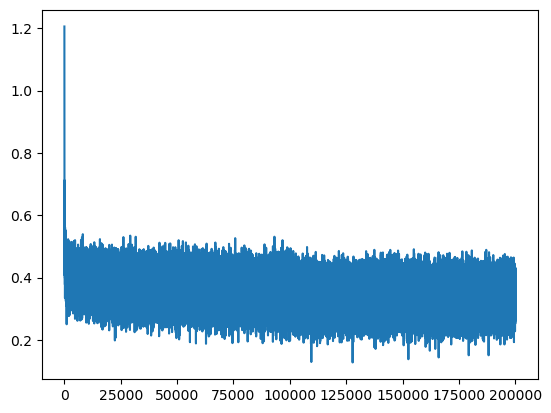

In [33]:
plt.plot(lossi)

In [34]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval), 
        'test': (Xtest, Ytest)
    }